# Using SimEc for recommender systems
Tasks like product recommendation or drug-target interaction prediction essentially consist of having to predict missing entries in a large matrix containing pairwise relations, e.g., the user ratings of some items or whether or not a drug interacts with a certain protein. Besides the sparse matrix containing the pairwise relations, generally one can also construct some feature vectors for the items and users (drugs / proteins), e.g., based on textual descriptions. These can come in especially handy when predictions need to be made, e.g., for new items that did not receive any user ratings so far. In the following we will only talk about items and users but of course this extends to other problem setups as well like drug-target interaction prediction. We distinguish between 3 tasks with increasing difficulty:
- **T1**: Predict missing ratings for existing items and users
- **T2a** and **T2b**: Predict ratings for new items and existing users (a) or new users and existing items (b)
- **T3**: Predict ratings for new items and new users

For tasks T2a/b and T3, feature vectors describing items and/or users are required. 

There are several methods that can be used to solve some or all of the above tasks. These include:
##### Baseline Methods
- **Predict average**: This is a no-brainer: simply fill all the missing values by averages. For example, an item rating from a user can be predicted based on the average rating the user usually gives (he might in general be more or less critical than other users) and the average rating the item got from other users (it might be better or worse than the average item) or for new items and users just predict the overall average rating (solves **T1, T2a/b, T3**).
- **SVD of the ratings matrix**: By factorizing the ratings matrix using (iterative) singular value decomposition (SVD), one can compute a low rank approximation of the ratings matrix and use these approximate values as predictions for the missing values (solves **T1**). This can also be combined with the average ratings from above, i.e., the low rank approximation can be used to predict the residuals.
- **SVD + Regression**: Given some feature vectors for items or users and the low rank approximation of the ratings matrix computed above, using a regression model, the mapping from the items' feature vectors to their rating vectors can be learned (or respectively for users). This is an extension of the above method to additionally solve either **T2a** or **T2b**, or **T3** if models are learned for both sides of the factorization.
- **Regression/Classification model**: This approach is completely different from the so-called latent factor models discussed above. Here we train an ordinary regression or classification model (depending on the form of the pairwise data, e.g. continuous ratings or binary interactions) by using as input the concatenation of the feature vectors of an item and a user and as the target their rating. One possible realization of such a model could involve two neural networks to map the individual feature vectors into some lower dimensional embedding space. This approach can be used to solve all tasks **T1, T2a/b, T3** provided corresponding feature vectors are available.

##### Similarity Encoder Models
- **Factorization of the ratings matrix using the identity matrix as input**: By training a SimEc to factorize the ratings matrix using the identity matrix as input, we can recreate the solution obtained with SVD (while possibly better handling missing values when computing the decomposition). Correspondingly, this only solves **T1**.
- **Factorization of the ratings matrix using feature vectors as input**: By using either item or user feature vectors as input when factorizing the ratings matrix, we can additionally solve **T2a** or **T2b**.
- **Train a second SimEc with feature vectors and fixed last layer weights**: After training, e.g., a SimEc with item feature vectors as input to decompose the ratings matrix, we can use this SimEc to compute the item embeddings $Y$. We can then construct a second SimEc, which uses user feature vectors as input to factorize the ratings matrix. However, here we fix the weights of the last layer by setting them to the transpose of the embedding matrix computed for the items. After this SimEc is trained, we can now use both SimEcs to compute item and user embeddings respectively and then compute the scalar product of the embedding vectors to predict the ratings. This approach can then also be used to predict the ratings given the feature vectors for new items and users, i.e., it can be used to solve all tasks **T1, T2a/b, T3**.

If the rating matrix contains explicit ratings (i.e. likes and dislikes), all available entries can be used to train the above models. If the pairwise relations in the matrix only represent implicit feedback or binary interactions (e.g. the user listens to music by certain artists, which means he likes them, but we don't know if he doesn't listen to other artists because he doesn't know them or because he doesn't like them), then we can use the given entries in the matrix as positive examples and additionally take a random sample of the missing entries and use them as negative examples. In the latter case, it might be more useful to use classification instead of regression models and also when training the SimEc it could be helpful to apply a non-linearity on the output before computing the error of the model.


### Dataset
In this notebook we work with the [movielens dataset](https://grouplens.org/datasets/movielens/10m/) and additionally pull some information about the individual movies from [the movie database](https://api.themoviedb.org/) using their API.

Since we only have additional information about the movies, not the users, we focus on solving tasks **T1** and **T2a** here.

In [1]:
from __future__ import unicode_literals
import os
import json
import requests
import numpy as np
np.random.seed(28)
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
tf.set_random_seed(28)
import keras

from collections import defaultdict
from scipy.sparse import lil_matrix, csr_matrix
from scipy.sparse.linalg import svds
from sklearn.metrics import mean_squared_error, mean_absolute_error
from simec import SimilarityEncoder

%matplotlib inline
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [2]:
if not os.path.exists("data/recsys/tmdb_data"):
    os.mkdir("data/recsys/tmdb_data")

def parse_tmdb(tmdbid, apikey):
    movie_data = {}
    if os.path.exists("data/recsys/tmdb_data/%r.json" % tmdbid):
        with open("data/recsys/tmdb_data/%r.json" % tmdbid) as f:
            movie_data = json.load(f)
    # for a movie with tmdbid get:
    # genres:name, original language en y/n, id, title, overview, release_date-->year,
    # keywords:keywords:name, credits:cast:name[:10], credits:crew:("job": "Director"):name
    if not movie_data:
        r = requests.get("https://api.themoviedb.org/3/movie/%r?api_key=%s&language=en-US&append_to_response=keywords,credits" % (tmdbid, apikey))
        if r.status_code != 200:
            print("something went wrong when accessing tmdb with id %r!" % tmdbid)
            print(r.text)
        else:
            movie_json = r.json()
            movie_data['tmdbid'] = movie_json['id']
            movie_data['title'] = movie_json['title']
            movie_data['overview'] = movie_json['overview']
            movie_data['release_date'] = movie_json['release_date']
            movie_data['year'] = movie_json["release_date"].split("-")[0]
            movie_data['original_en'] = str(movie_json['original_language'] == "en")
            movie_data['genres'] = [g["name"] for g in movie_json['genres']]
            movie_data['keywords'] = [k["name"] for k in movie_json['keywords']['keywords']]
            movie_data['cast'] = [c["name"] for c in movie_json['credits']['cast'][:10]]
            movie_data['directors'] = [c["name"] for c in movie_json['credits']['crew'] if c["job"] == "Director"]
            print("got data for %s" % movie_json['title'])
            with open("data/recsys/tmdb_data/%r.json" % tmdbid, "w") as f:
                json.dump(movie_data, f, indent=2)
    return movie_data

In [3]:
# get movielens data from: https://grouplens.org/datasets/movielens/10m/
# load all possible movies (in the 10m dataset)
df_movies = pd.read_csv("data/recsys/ml-10M100K/movies.dat", sep="::", names=["movieId","title","genres"])
# get corresponding tmdbids (only in 20m dataset)
df_links = pd.read_csv("data/recsys/ml-20m/links.csv")
df_links = df_links.dropna()
df_links = df_links.astype(int) 
map_movieids = dict(zip(df_links.movieId, df_links.tmdbId))
# get additional details from themoviedb.org (assumes api key is stored at data/recsys/tmdb_apikey.txt)
if os.path.exists("data/recsys/tmdb_data.json"):
    with open("data/recsys/tmdb_data.json") as f:
        movies_data = json.load(f)
else:
    movies_data = {}
    with open('data/recsys/tmdb_apikey.txt') as f:
        apikey = f.read().strip()
    for movieid in df_movies.movieId:
        if movieid in map_movieids:
            m = parse_tmdb(map_movieids[movieid], apikey)
            if m:
                # careful: when loading the json later the ids will be strings as well anyways
                movies_data[str(movieid)] = m
            else:
                print("error with movie id: %i" % movieid)
    with open("data/recsys/tmdb_data.json", "w") as f:
        json.dump(movies_data, f, indent=2)
print("got data for %i movies" % len(movies_data))

/home/franzi/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  This is separate from the ipykernel package so we can avoid doing imports until


got data for 10608 movies


In [4]:
# load pairwise data and generate a dict with {(movieid, userid): rating}
movieids = set()
userids = set()
tuple_ratings = {}
rating_pairs = []
with open("data/recsys/ml-10M100K/ratings.dat") as f:
    for i, l in enumerate(f.readlines()):
        if not i % 1000000:
            print("parsed %i lines" % i)
        u, m, r, t = l.strip().split("::")
        # only consider ratings for movies where we have external data available
        if m in movies_data:
            # in addition to the ratings, also get a list of all users and movies
            if u not in userids:
                userids.add(u)
            if m not in movieids:
                movieids.add(m)
            tuple_ratings[(m,u)] = float(r)
            rating_pairs.append((m,u))
        #else:
        #    print("warning, skipping rating for movie with id %r" % m)
# shuffle all movie and user ids (important so we can split data into train and test sets)
# this list additionally functions as a mapping from a (matrix) index to the actual id
np.random.seed(13)
map_index2movieid = np.random.permutation(sorted(movieids))
map_index2userid = np.random.permutation(sorted(userids))
# also get a shuffeled list of all rating pairs
rating_pairs = np.random.permutation(rating_pairs)
print("%i movies, %i users, and %i ratings" % (len(movieids), len(userids), len(rating_pairs)))

parsed 0 lines
parsed 1000000 lines
parsed 2000000 lines
parsed 3000000 lines
parsed 4000000 lines
parsed 5000000 lines
parsed 6000000 lines
parsed 7000000 lines
parsed 8000000 lines
parsed 9000000 lines
parsed 10000000 lines
10604 movies, 69878 users, and 9989664 ratings


In [5]:
# we have different scenarios: either we're only missing some individual ratings or entire movies/users
def split_traintest(scenario):
    print("generating train/test splits for scenario %r" % scenario)
    if scenario == "T1":
        # missing ratings
        rating_pairs_train = rating_pairs[:int(0.7*len(rating_pairs))]
        rating_pairs_test = rating_pairs[int(0.7*len(rating_pairs)):]
        map_index2movieid_train = map_index2movieid
        map_index2userid_train = map_index2userid
    else:
        rating_pairs_train = []
        rating_pairs_test = []
        if scenario == "T2a":
            # missing movies
            map_index2movieid_train = map_index2movieid[:int(0.7*len(map_index2movieid))]
            map_index2userid_train = map_index2userid
        elif scenario == "T2b":
            # missing users
            map_index2movieid_train = map_index2movieid
            map_index2userid_train = map_index2userid[:int(0.7*len(map_index2userid))]
        elif scenario == "T3":
            # missing movies and users
            map_index2movieid_train = map_index2movieid[:int(0.85*len(map_index2movieid))]
            map_index2userid_train = map_index2userid[:int(0.8*len(map_index2userid))]
        else:
            raise Exception("unknown scenario %r, use either T1, T2a, T2b, or T3!" % scenario)
        movieids_train_set = set(map_index2movieid_train)
        userids_train_set = set(map_index2userid_train)
        rating_pairs_train = []
        rating_pairs_test = []
        for (m, u) in rating_pairs:
            if u in userids_train_set and m in movieids_train_set:
                rating_pairs_train.append((m, u))
            else:
                rating_pairs_test.append((m, u))
    print("got %i training and %i test ratings" % (len(rating_pairs_train), len(rating_pairs_test)))
    # create mappings from the actual id to the index
    map_movieid2index_train = {m: i for i, m in enumerate(map_index2movieid_train)}
    map_userid2index_train = {u: i for i, u in enumerate(map_index2userid_train)}
    return rating_pairs_train, rating_pairs_test, map_index2userid_train,\
           map_index2movieid_train, map_userid2index_train, map_movieid2index_train

def make_train_matrix(tuple_ratings, rating_pairs_train, map_userid2index_train, map_movieid2index_train):
    # transform training ratings into a sparse matrix for convenience
    print("transforming dict with %i ratings into sparse matrix" % len(rating_pairs_train))
    ratings_matrix = lil_matrix((len(map_movieid2index_train),len(map_userid2index_train)))
    for (m, u) in rating_pairs_train:
        ratings_matrix[map_movieid2index_train[m],map_userid2index_train[u]] = tuple_ratings[(m, u)]
    ratings_matrix = csr_matrix(ratings_matrix)
    return ratings_matrix

In [6]:
class MeansModel():
    """
    A very simple baseline model, which predicts the rating a user would give to a movie as:
        mean + user_mean + movie_mean
    """
    def __init__(self, shrinkage=1.):
        self.mean = None
        self.mean_users = {}
        self.mean_movies = {}
        # shrinkage decreases the influence of the individual user/movie means
        # --> mean + shrinkage*user_mean + shrinkage*movie_mean
        # it should always be between 0 and 1; 0 means individual means are ignored
        self.shrinkage = max(0., min(1., shrinkage))

    def fit(self, tuple_ratings, rating_pairs_train):
        # overall mean based on all training ratings
        self.mean = np.mean([tuple_ratings[(m, u)] for (m, u) in rating_pairs_train])
        # means for movies and users
        if self.shrinkage:
            mean_users = defaultdict(list)
            mean_movies = defaultdict(list)
            for (m, u) in rating_pairs_train:
                mean_users[u].append(tuple_ratings[(m, u)])
                mean_movies[m].append(tuple_ratings[(m, u)])
            self.mean_users = {u: np.mean(mean_users[u])-self.mean for u in mean_users}
            self.mean_movies = {m: np.mean(mean_movies[m])-self.mean for m in mean_movies}
    
    def predict(self, m, u, residuals=None):
        """
        generate rating prediction for a user u and movie m
        """
        rating = self.mean
        if u in self.mean_users:
            rating += self.shrinkage*self.mean_users[u]
        if m in self.mean_movies:
            rating += self.shrinkage*self.mean_movies[m]
        if residuals and (m, u) in residuals:
            rating += residuals[(m, u)]
        return rating
    
    def compute_residuals(self, tuple_ratings, rating_pairs_train):
        """
        for all ratings, subtract the respective average ratings to get residuals
        """
        return {(m, u): tuple_ratings[(m, u)] - (self.mean+self.shrinkage*(self.mean_users[u]+self.mean_movies[m]))
                                  for (m, u) in rating_pairs_train}

In [34]:
for scenario in ["T1", "T2a", "T2b", "T3"]:
    # get train/test data
    rating_pairs_train, rating_pairs_test, map_index2userid_train, map_index2movieid_train, map_userid2index_train, map_movieid2index_train = split_traintest(scenario)
    for shrinkage in [0., 0.1, 0.5, 0.9, 1.]:
        # initalize means model
        mmodel = MeansModel(shrinkage)
        print("fitting model with shrinkage=%.1f" % shrinkage)
        mmodel.fit(tuple_ratings, rating_pairs_train)
        # get a vector with target ratings for test tuples
        y_true = np.array([tuple_ratings[(m, u)] for (m, u) in rating_pairs_test])
        # get the corresponding predictions
        y_pred = np.array([mmodel.predict(m, u) for (m, u) in rating_pairs_test])
        print("Scenario %s: RMSE: %.5f; MAE: %.5f" % (scenario, np.sqrt(mean_squared_error(y_true, y_pred)), mean_absolute_error(y_true, y_pred)))

generating train/test splits for scenario u'T1'
got 6992764 training and 2996900 test ratings
fitting model with shrinkage=0.0
Scenario T1: RMSE: 1.06044; MAE: 0.85552
fitting model with shrinkage=0.1
Scenario T1: RMSE: 1.02330; MAE: 0.82574
fitting model with shrinkage=0.5
Scenario T1: RMSE: 0.91333; MAE: 0.71937
fitting model with shrinkage=0.9
Scenario T1: RMSE: 0.88074; MAE: 0.68157
fitting model with shrinkage=1.0
Scenario T1: RMSE: 0.88614; MAE: 0.68404
generating train/test splits for scenario u'T2a'
got 7064138 training and 2925526 test ratings
fitting model with shrinkage=0.0
Scenario T2a: RMSE: 1.05938; MAE: 0.85143
fitting model with shrinkage=0.1
Scenario T2a: RMSE: 1.04342; MAE: 0.83821
fitting model with shrinkage=0.5
Scenario T2a: RMSE: 0.99569; MAE: 0.79322
fitting model with shrinkage=0.9
Scenario T2a: RMSE: 0.97628; MAE: 0.76558
fitting model with shrinkage=1.0
Scenario T2a: RMSE: 0.97610; MAE: 0.76332
generating train/test splits for scenario u'T2b'
got 7015197 train

In [7]:
scenario = "T1"
# get train/test data
rating_pairs_train, rating_pairs_test, map_index2userid_train, map_index2movieid_train, map_userid2index_train, map_movieid2index_train = split_traintest(scenario)
# initalize and fit means model
mmodel = MeansModel()
mmodel.fit(tuple_ratings, rating_pairs_train)
# get sparse matrix with residuals
print("computing residuals")
residual_ratings = mmodel.compute_residuals(tuple_ratings, rating_pairs_train)
ratings_matrix = make_train_matrix(residual_ratings, rating_pairs_train, map_userid2index_train, map_movieid2index_train)

generating train/test splits for scenario u'T1'
got 6992764 training and 2996900 test ratings
computing residuals
transforming dict with 6992764 ratings into sparse matrix


Text(0.5,0,u'eigenvalue')

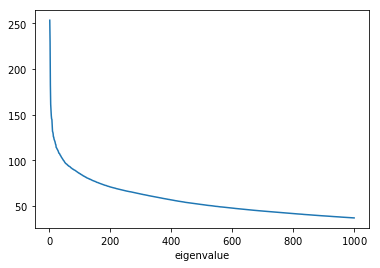

In [33]:
# inspect eigenvalues of matrix
eigenvals = svds(ratings_matrix, k=1000, return_singular_vectors=False)
eigenvals = sorted(eigenvals, reverse=True)
plt.figure()
plt.plot(range(1, len(eigenvals)+1), eigenvals)
plt.xlabel("eigenvalue")

In [34]:
# get eigenvalues and -vectors for some relevant dimensions
e_dim = 100
U, s, Vh = svds(ratings_matrix, k=e_dim)
S = np.zeros((e_dim, e_dim))
S = np.diag(s)
U.shape, S.shape, Vh.shape

((10604, 100), (100, 100), (100, 69878))

In [35]:
# construct approximation of residual ratings
print("get approximations")
temp = np.dot(U, np.dot(S, Vh))
# get dict with residuals for missing test ratings
print("get residual ratings")
residual_ratings_test = {(m, u): temp[map_movieid2index_train[m], map_userid2index_train[u]]
                                 for (m, u) in rating_pairs_test}
del temp
print("predict test ratings")
# get a vector with target ratings for test tuples
y_true = np.array([tuple_ratings[(m, u)] for (m, u) in rating_pairs_test])
# get the corresponding predictions
y_pred = np.array([mmodel.predict(m, u, residual_ratings_test) for (m, u) in rating_pairs_test])
print("Scenario %s: RMSE: %.5f; MAE: %.5f" % (scenario, np.sqrt(mean_squared_error(y_true, y_pred)), mean_absolute_error(y_true, y_pred)))

get approximations
get residual ratings
predict test ratings
Scenario T1: RMSE: 0.85891; MAE: 0.65994


In [17]:
# get a vector with target ratings for test tuples
y_true = np.array([tuple_ratings[(m, u)] for (m, u) in rating_pairs_test])
# train simec with identiy matrix as input to predict residuals
e_dim = 100
X = np.eye(ratings_matrix.shape[0], dtype=np.float16)
R = -100*np.ones(ratings_matrix.shape, dtype=np.float16)
R[ratings_matrix.nonzero()] = ratings_matrix[ratings_matrix.nonzero()]
for l in [0.1]:
    print l
    model = SimilarityEncoder(ratings_matrix.shape[0], e_dim, ratings_matrix.shape[1], mask_value=-100,
                              opt=0.05)
    model.fit(X, ratings_matrix, epochs=20)
    print("get approximations")
    temp = np.array(model.predict(X), dtype=np.float16)
    # get dict with residuals for missing test ratings
    print("get residual ratings")
    residual_ratings_test = {(m, u): temp[map_movieid2index_train[m], map_userid2index_train[u]]
                                     for (m, u) in rating_pairs_test}
    del temp
    print("predict test ratings")
    # get the corresponding predictions
    y_pred = np.array([mmodel.predict(m, u, residual_ratings_test) for (m, u) in rating_pairs_test])
    print("Scenario %s: RMSE: %.5f; MAE: %.5f" % (scenario, np.sqrt(mean_squared_error(y_true, y_pred)), mean_absolute_error(y_true, y_pred)))
del R

0.1
Epoch 1/20
10604/10604 [==============================] - 7s 683us/step - loss: 0.0075
Epoch 2/20
10604/10604 [==============================] - 7s 650us/step - loss: 0.0074
Epoch 3/20
10604/10604 [==============================] - 7s 642us/step - loss: 0.0075
Epoch 4/20
10604/10604 [==============================] - 7s 643us/step - loss: 0.0075
Epoch 5/20
10604/10604 [==============================] - 7s 635us/step - loss: 0.0075
Epoch 6/20
10604/10604 [==============================] - 7s 651us/step - loss: 0.0075
Epoch 7/20
10604/10604 [==============================] - 7s 643us/step - loss: 0.0075
Epoch 8/20
10604/10604 [==============================] - 7s 644us/step - loss: 0.0075
Epoch 9/20
10604/10604 [==============================] - 7s 650us/step - loss: 0.0075
Epoch 10/20
10604/10604 [==============================] - 7s 649us/step - loss: 0.0075
Epoch 11/20
10604/10604 [==============================] - 7s 644us/step - loss: 0.0075
Epoch 12/20
10604/10604 [============

KeyboardInterrupt: 